In [1]:
import copy
import random
from collections import defaultdict

import numpy as np
import tqdm
from IPython import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

In [2]:
class RiverSwim:
    def __init__(self, current='WEAK', seed=1234):
        self.num_states = 6
        self.num_actions = 2  # O <=> LEFT, 1 <=> RIGHT

        # Larger current makes it harder to swim up the river
        self.currents = ['WEAK', 'MEDIUM', 'STRONG']
        assert current in self.currents
        self.current = self.currents.index(current) + 1
        assert self.current in [1, 2, 3]

        # Configure reward function
        R = np.zeros((self.num_states, self.num_actions))
        R[0, 0] = 0.005
        R[5, 1] = 0.6

        # Configure transition function
        T = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Encode initial and rewarding state transitions
        left, right = 0, 1
        T[0, left, 0] = 1.
        T[0, right, 0] = 0.4
        T[0, right, 1] = 0.6

        T[5, left, 4] = 1.
        T[5, right, 5] = 0.6
        T[5, right, 4] = 0.4

        # Encode intermediate state transitions
        for s in range(1, self.num_states - 1):
            # Going left always succeeds
            T[s, left, s - 1] = 1.

            # Going right sometimes succeeds
            T[s, right, s] = 0.6
            T[s, right, s - 1] = 0.05 * self.current
            T[s, right, s + 1] = 0.4 - 0.05 * self.current
            assert np.isclose(np.sum(T[s, right]), 1.)

        self.R = np.array(R)
        self.T = np.array(T)

        # Agent always starts at the opposite end of the river
        self.init_state = 0
        self.curr_state = self.init_state

        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_model(self):
        return copy.deepcopy(self.R), copy.deepcopy(self.T)

    def reset(self):
        self.init_state = np.random.randint(self.num_states)
        self.curr_state = self.init_state
        return self.curr_state

    def step(self, action):
        reward = self.R[self.curr_state, action]
        next_state = np.random.choice(np.arange(self.num_states), p=self.T[self.curr_state, action])
        self.curr_state = next_state
        return reward, next_state


In [3]:
# collect dataset
seed = 100
discount = 0.99
env = RiverSwim(seed=seed)

# uniform behavioral policy
behavioral_policy = np.ones([env.num_states, env.num_actions]) / env.num_actions

dataset = defaultdict(list)

# dataset size = 1M
num_episodes = 100
max_episode_steps = 1001
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    obs = env.reset()
    for step in range(max_episode_steps):
        action = np.random.choice(np.arange(env.num_actions), p=behavioral_policy[obs])
        reward, next_obs = env.step(action)
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['rewards'].append(reward)
        
        obs = next_obs

    for k, v in traj_dataset.items():
        dataset[k].append(v)

train_dataset = {}
for k, v in dataset.items():
    if 'observations' in k or 'actions' in k:
        dtype = np.int32
    else:
        dtype = np.float32
    arr = np.array(v, dtype=dtype)[:, :-1]
    train_dataset[k] = arr.reshape(-1)
arr = np.array(dataset['actions'], np.int32)[:, 1:]
train_dataset['next_actions'] = arr.reshape(-1)

100%|██████████| 100/100 [00:05<00:00, 19.10it/s]


In [4]:
# value iteration to find the optimal Q
rewards, transition_probs = env.get_model()

opt_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_q = (1 - discount) * rewards + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.num_states, env.num_actions])
opt_policy[np.arange(env.num_states), np.argmax(opt_q, axis=-1)] = 1.0

# value iteration to find the behavioral Q
rewards, transition_probs = env.get_model()

behavioral_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  behavioral_q = (1 - discount) * rewards + discount * np.einsum('ijk,k->ij', transition_probs, np.sum(behavioral_policy * behavioral_q, axis=-1))
behavioral_v = np.sum(behavioral_policy * behavioral_q, axis=-1)

In [ ]:
print("optimal q and optimal policy: ")
print(opt_q)
print(opt_policy)

print("behavioral q: ")
print(behavioral_q)

optimal q and optimal policy: 
[[0.22490692 0.22712821]
 [0.22485692 0.23095191]
 [0.22864239 0.23816344]
 [0.2357818  0.24606706]
 [0.24360639 0.25429765]
 [0.25175467 0.26281249]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
behavioral q: 
[[0.00217771 0.0021207 ]
 [0.00212771 0.00214708]
 [0.00211602 0.00233464]
 [0.00220308 0.0030321 ]
 [0.00259141 0.00529948]
 [0.00390599 0.0124075 ]]


### Augmented env

In [5]:
class AugmentedRiverSwim:
    def __init__(self, discount=0.99, current='WEAK', seed=1234):
        self.num_states = 6 + 2  # add s_plus and s_minus
        self.num_actions = 2  # O <=> LEFT, 1 <=> RIGHT
        
        self.discount = discount
        # Larger current makes it harder to swim up the river
        self.currents = ['WEAK', 'MEDIUM', 'STRONG']
        assert current in self.currents
        self.current = self.currents.index(current) + 1
        assert self.current in [1, 2, 3]

        # Configure reward function
        left, right = 0, 1
        orig_R = np.zeros((self.num_states, self.num_actions))
        orig_R[0, left] = 0.005
        orig_R[5, right] = 0.6

        # Configure transition function
        T = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Encode initial and rewarding state transitions
        T[0, left, 0] = 1.
        T[0, right, 0] = 0.4
        T[0, right, 1] = 0.6

        T[5, left, 4] = 1.
        T[5, right, 5] = 0.6
        T[5, right, 4] = 0.4

        # Encode intermediate state transitions
        for s in range(1, self.num_states - 3):
            # Going left always succeeds
            T[s, left, s - 1] = 1.

            # Going right sometimes succeeds
            T[s, right, s] = 0.6
            T[s, right, s - 1] = 0.05 * self.current
            T[s, right, s + 1] = 0.4 - 0.05 * self.current
            assert np.isclose(np.sum(T[s, right]), 1.)

        # discount every transitions
        T *= discount
        
        # transite to s+ and s- using r(s, a)
        T[:self.num_states - 2, :, 6] = (1. - discount) * orig_R[:self.num_states - 2]
        T[:self.num_states - 2, :, 7] = (1. - discount) * (1. - orig_R[:self.num_states - 2])
        
        T[6, left, 6] = 1.
        T[6, right, 6] = 1.
        T[7, left, 7] = 1.
        T[7, right, 7] = 1.
        
        assert np.all(np.isclose(np.sum(T, axis=-1), 1.))
        
        R = np.zeros((self.num_states, self.num_actions))
        R[6] = 1.0
        self.R = np.array(R)
        self.T = np.array(T)

        # Agent always starts at the opposite end of the river
        self.init_state = 0
        self.curr_state = self.init_state

        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_model(self):
        return copy.deepcopy(self.R), copy.deepcopy(self.T)

    def reset(self):
        # the initial state distribution is the same as the original MDP
        self.init_state = np.random.randint(self.num_states - 2)
        self.curr_state = self.init_state
        return self.curr_state

    def step(self, action):
        reward = self.R[self.curr_state, action]
        next_state = np.random.choice(np.arange(self.num_states), p=self.T[self.curr_state, action])
        self.curr_state = next_state
        return reward, next_state


In [7]:
# collect dataset
seed = 100
discount = 0.99
augmented_env = AugmentedRiverSwim(discount=discount, seed=seed)

# uniform behavioral policy
behavioral_policy = np.ones([augmented_env.num_states, augmented_env.num_actions]) / augmented_env.num_actions

augmented_dataset = defaultdict(list)

# dataset size = 100K
num_episodes = 100
max_episode_steps = 1001
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_env.reset()
    for step in range(max_episode_steps):
        action = np.random.choice(np.arange(augmented_env.num_actions), p=behavioral_policy[obs])
        reward, next_obs = augmented_env.step(action)
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['rewards'].append(reward)
        
        obs = next_obs

    for k, v in traj_dataset.items():
        augmented_dataset[k].append(v)

augmented_train_dataset = {}
for k, v in augmented_dataset.items():
    if 'observations' in k or 'actions' in k:
        dtype = np.int32
    else:
        dtype = np.float32
    arr = np.array(v, dtype=dtype)[:, :-1]
    augmented_train_dataset[k] = arr.reshape(-1)
arr = np.array(augmented_dataset['actions'], np.int32)[:, 1:]
augmented_train_dataset['next_actions'] = arr.reshape(-1)

100%|██████████| 100/100 [00:05<00:00, 19.73it/s]


In [9]:
print(augmented_env.get_model()[1][0, 0])
print(augmented_env.get_model()[1][1, 0])
print(augmented_env.get_model()[1][2, 0])
print(augmented_env.get_model()[1][3, 0])
print(augmented_env.get_model()[1][4, 0])
print(augmented_env.get_model()[1][5, 0])
print(augmented_env.get_model()[1][6, 0])
print(augmented_env.get_model()[1][7, 0])

print("---")
print(augmented_env.get_model()[1][0, 1])
print(augmented_env.get_model()[1][1, 1])
print(augmented_env.get_model()[1][2, 1])
print(augmented_env.get_model()[1][3, 1])
print(augmented_env.get_model()[1][4, 1])
print(augmented_env.get_model()[1][5, 1])
print(augmented_env.get_model()[1][6, 1])
print(augmented_env.get_model()[1][7, 1])

print("---")
print(augmented_env.get_model()[0])

[9.90e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.00e-05 9.95e-03]
[0.99 0.   0.   0.   0.   0.   0.   0.01]
[0.   0.99 0.   0.   0.   0.   0.   0.01]
[0.   0.   0.99 0.   0.   0.   0.   0.01]
[0.   0.   0.   0.99 0.   0.   0.   0.01]
[0.   0.   0.   0.   0.99 0.   0.   0.01]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
---
[0.396 0.594 0.    0.    0.    0.    0.    0.01 ]
[0.0495 0.594  0.3465 0.     0.     0.     0.     0.01  ]
[0.     0.0495 0.594  0.3465 0.     0.     0.     0.01  ]
[0.     0.     0.0495 0.594  0.3465 0.     0.     0.01  ]
[0.     0.     0.     0.0495 0.594  0.3465 0.     0.01  ]
[0.    0.    0.    0.    0.396 0.594 0.006 0.004]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
---
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]]


In [10]:
# value iteration to find the optimal Q in the MDP using gamma ** 2
rewards, transition_probs = env.get_model()

opt_q_square_discount = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_q_square_discount = (1 - discount ** 2) * rewards + discount ** 2 * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q_square_discount, axis=-1))

In [11]:
# value iteration to find the optimal discounted state occupancy measure in the GCMDP using gamma
rewards, transition_probs = augmented_env.get_model()

opt_d_sa = np.zeros([augmented_env.num_states, augmented_env.num_actions, augmented_env.num_states], dtype=np.float32)
for _ in range(10_000):
  opt_a = np.argmax(opt_d_sa[..., augmented_env.num_states - 2], axis=-1)
  opt_pi = np.zeros((augmented_env.num_states, augmented_env.num_actions))
  opt_pi[np.arange(augmented_env.num_states), opt_a] = 1.
  # opt_d_sa = (1 - discount) * np.eye(augmented_env.num_states)[:, None] + discount * np.einsum('ijk,kl->ijl', transition_probs, np.sum(opt_d_sa * opt_pi[..., None], axis=1))
  opt_d_sa = (1 - discount) * np.eye(augmented_env.num_states)[:, None] + discount * np.einsum('ijk,kl->ijl', transition_probs, np.sum(opt_d_sa * opt_pi[..., None], axis=1))

opt_a = np.argmax(opt_d_sa[..., augmented_env.num_states - 2], axis=-1)
opt_pi = np.zeros((augmented_env.num_states, augmented_env.num_actions))
opt_pi[np.arange(augmented_env.num_states), opt_a] = 1.

opt_d_s = np.sum(opt_d_sa * opt_pi[..., None], axis=1)

In [17]:
# evaluation the optimal pi
seed = 100
augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed)

eval_dataset = defaultdict(list)
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_eval_env.reset()
    for step in range(max_episode_steps):
        action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=opt_pi[obs])
        reward, next_obs = augmented_eval_env.step(action)
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['rewards'].append(reward)
        
        obs = next_obs

    for k, v in traj_dataset.items():
        eval_dataset[k].append(v)

for k, v in eval_dataset.items():
    eval_dataset[k] = np.asarray(v)

sr = np.mean(np.any(eval_dataset['rewards'] == 1.0, axis=-1))
print("success rate = {}".format(sr))


100%|██████████| 100/100 [00:04<00:00, 22.46it/s]

success rate = 0.25


In [18]:
print("scaled optimal d_gamma(s+ | s, a) and optimal policy: ")
scaled_opt_d_sa_splus = opt_d_sa[..., augmented_env.num_states - 2] * (1 + discount) / discount
print(scaled_opt_d_sa_splus)
print(opt_pi)

print("optimal Q_gamma^2(s, a): ")
print(opt_q_square_discount)

assert np.allclose(scaled_opt_d_sa_splus[:augmented_env.num_states - 2], opt_q_square_discount)

scaled optimal d_gamma(s+ | s, a) and optimal policy: 
[[0.1972363  0.20113947]
 [0.1971368  0.20794605]
 [0.20380792 0.2209817 ]
 [0.21658416 0.23566343]
 [0.23097373 0.25143202]
 [0.24642853 0.26827065]
 [2.01010101 2.01010101]
 [0.         0.        ]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
optimal Q_gamma^2(s, a): 
[[0.1972363  0.20113947]
 [0.1971368  0.20794605]
 [0.20380792 0.2209817 ]
 [0.21658416 0.23566343]
 [0.23097373 0.25143202]
 [0.24642853 0.26827065]]


In [19]:
# value iteration to compute the optimal goal-conditioned Q in the GCMDP using gamma
rewards, transition_probs = augmented_env.get_model()

opt_gc_q = np.zeros([augmented_env.num_states, augmented_env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_gc_q = (1 - discount) * rewards + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_gc_q, axis=-1))
  
scaled_opt_gc_q = opt_gc_q * (1 + discount) / discount

assert np.allclose(scaled_opt_d_sa_splus[:augmented_env.num_states - 2], scaled_opt_gc_q[:augmented_env.num_states - 2])
assert np.allclose(opt_q_square_discount, scaled_opt_gc_q[:augmented_env.num_states - 2])

print("scaled optimal goal-conditioned Q: ")
print(scaled_opt_gc_q[:env.num_states])

scaled optimal goal-conditioned Q: 
[[0.1972363  0.20113947]
 [0.1971368  0.20794605]
 [0.20380792 0.2209817 ]
 [0.21658416 0.23566343]
 [0.23097373 0.25143202]
 [0.24642853 0.26827065]]


#### Utils

In [20]:
def sample_batch(batch_size):
    dataset_size = len(train_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], train_dataset)
    
    return batch

In [21]:
terminal_locs = (np.arange(num_episodes) + 1) * (max_episode_steps - 1) - 1

def sample_augmented_batch(batch_size, p_curgoal=0.2, p_trajgoal=0.5, relabel_reward=False):
    dataset_size = len(augmented_train_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], augmented_train_dataset)
    
    final_state_idxs = terminal_locs[np.searchsorted(terminal_locs, idxs)]
    
    offsets = np.random.geometric(p=1 - discount, size=batch_size)  # in [1, inf)
    traj_goal_idxs = np.minimum(idxs + offsets, final_state_idxs)
    random_goal_idxs = np.random.randint(dataset_size, size=batch_size)
    goal_idxs = np.where(
        np.random.rand(batch_size) < p_trajgoal / (1.0 - p_curgoal), traj_goal_idxs, random_goal_idxs
    )
    goal_idxs = np.where(np.random.rand(batch_size) < p_curgoal, idxs, goal_idxs)

    batch['goals'] = jax.tree_util.tree_map(lambda arr: arr[goal_idxs], augmented_train_dataset['observations'])
    if relabel_reward:
        batch['rewards'] = (idxs == goal_idxs).astype(float)
    
    return batch

In [22]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

### Q-Learning

In [24]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.num_states)
    action = jax.nn.one_hot(action, env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

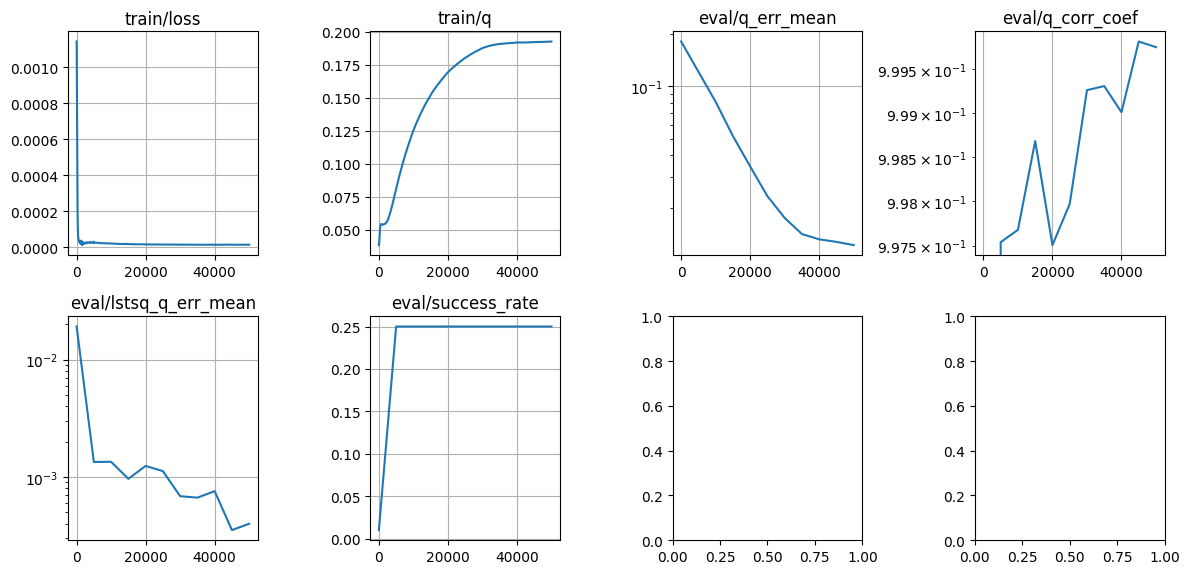

100%|██████████| 50000/50000 [02:05<00:00, 399.42it/s] 


In [25]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount ** 2) * batch['rewards'] + discount ** 2 * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  eval_dataset = defaultdict(list)
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_eval_env.reset()
    for _ in range(max_episode_steps):
      action = np.random.choice(np.arange(augmented_env.num_actions), p=pi[obs])
      reward, next_obs = augmented_eval_env.step(action)
      
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs

    for k, v in traj_dataset.items():
      eval_dataset[k].append(v)

  for k, v in eval_dataset.items():
    eval_dataset[k] = np.asarray(v)

  sr = np.mean(np.any(eval_dataset['rewards'] == 1.0, axis=-1))

  return sr

def evaluate_fn(params):
  obs = jnp.arange(env.num_states)[:, None].repeat(env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(env.num_actions)[None, :].repeat(env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([env.num_states, env.num_actions])
  # scaled_q = q * (opt_q_square_discount / q).mean()
  # q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  # scaled_q_err_mean = jnp.mean(np.abs(scaled_q - opt_q_square_discount))
  # q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [26]:
q_learning_metrics = metrics
print(q_learning_metrics['eval/q_err_mean'][-1])
print(q_learning_metrics['eval/q_corr_coef'][-1])
print(q_learning_metrics['eval/lstsq_q_err_mean'][-1])
print(q_learning_metrics['eval/success_rate'][-1])

[5.00000000e+04 1.22471284e-02]
[5.00000000e+04 9.99746919e-01]
[5.00000000e+04 3.99650395e-04]
[5.0e+04 2.5e-01]


### SGCQL

In [28]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)
    
    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

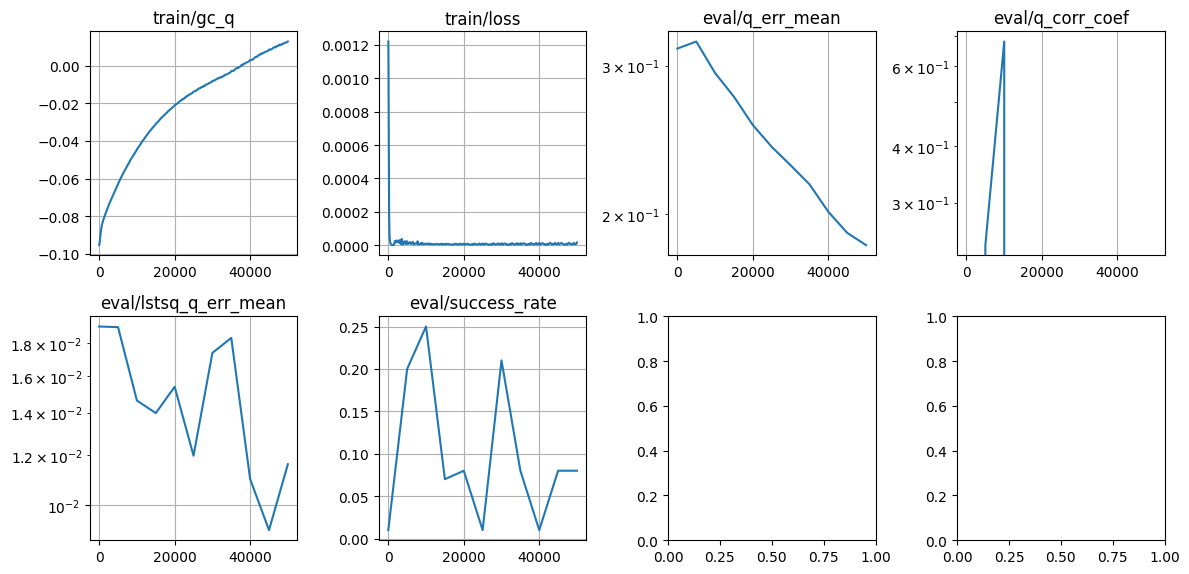

100%|██████████| 50000/50000 [02:14<00:00, 371.44it/s]


In [29]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'gc_q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  eval_dataset = defaultdict(list)
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_eval_env.reset()
    for _ in range(max_episode_steps):
      action = np.random.choice(np.arange(augmented_env.num_actions), p=pi[obs])
      reward, next_obs = augmented_eval_env.step(action)
      
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs

    for k, v in traj_dataset.items():
      eval_dataset[k].append(v)

  for k, v in eval_dataset.items():
    eval_dataset[k] = np.asarray(v)

  sr = np.mean(np.any(eval_dataset['rewards'] == 1.0, axis=-1))

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions)
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = gc_q[:env.num_states]
  q = q * (1 + discount) / discount
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [30]:
sgcql_metrics = metrics
print(sgcql_metrics['eval/q_err_mean'][-1])
print(sgcql_metrics['eval/q_corr_coef'][-1])
print(sgcql_metrics['eval/lstsq_q_err_mean'][-1])
print(sgcql_metrics['eval/success_rate'][-1])

[5.0000000e+04 1.8381539e-01]
[ 5.00000000e+04 -7.02881217e-01]
[5.00000000e+04 1.16028674e-02]
[5.e+04 8.e-02]


In [31]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
gc_q = critic.apply(critic_params, obs, actions)
gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
gc_a = jnp.argmax(gc_q, axis=-1)
pi = jax.nn.one_hot(gc_a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)


pi: 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### GCQL + HER

In [34]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action, goals):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    goals = jax.nn.one_hot(goals, augmented_env.num_states)
    inputs = jnp.concatenate([obs, action, goals], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

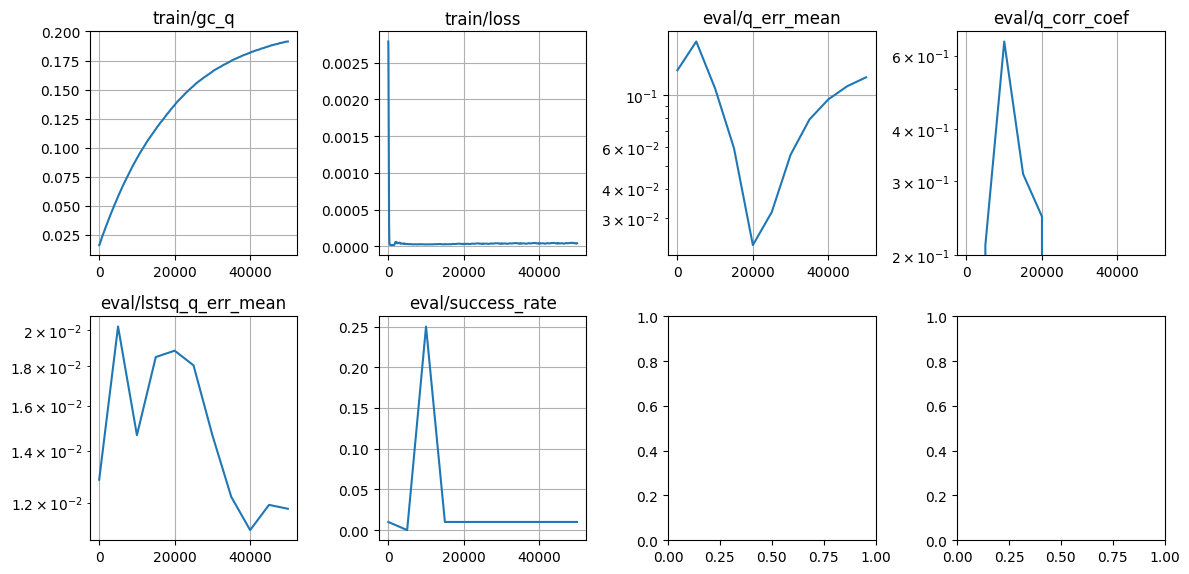

100%|██████████| 50000/50000 [02:13<00:00, 374.03it/s]


In [35]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, relabel_reward=True)
critic = Critic()
critic_params = critic.init(critic_key, 
                            example_batch['observations'], 
                            example_batch['actions'], 
                            example_batch['goals'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'], batch['goals'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), batch['goals'])
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), batch['goals'])
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'gc_q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  eval_dataset = defaultdict(list)
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_eval_env.reset()
    for _ in range(max_episode_steps):
      action = np.random.choice(np.arange(augmented_env.num_actions), p=pi[obs])
      reward, next_obs = augmented_eval_env.step(action)
      
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs

    for k, v in traj_dataset.items():
      eval_dataset[k].append(v)

  for k, v in eval_dataset.items():
    eval_dataset[k] = np.asarray(v)

  sr = np.mean(np.any(eval_dataset['rewards'] == 1.0, axis=-1))

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = gc_q[:env.num_states]
  q = q * (1 + discount) / discount
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, relabel_reward=True)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [38]:
gcql_her_metrics = metrics
print(gcql_her_metrics['eval/q_err_mean'][-1])
print(gcql_her_metrics['eval/q_corr_coef'][-1])
print(gcql_her_metrics['eval/lstsq_q_err_mean'][-1])
print(gcql_her_metrics['eval/success_rate'][-1])

[5.00000000e+04 1.18569255e-01]
[ 5.00000000e+04 -6.69636786e-01]
[5.00000000e+04 1.17835272e-02]
[5.e+04 1.e-02]


In [39]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
q = critic.apply(critic_params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
a = jnp.argmax(q, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

pi: 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### CRL + Binary NCE

In [42]:
large_batch = sample_augmented_batch(1_000_000, p_curgoal=0.0, p_trajgoal=1.0)

goal_marg = np.zeros(augmented_env.num_states)
for state in range(augmented_env.num_states):
    goal_marg[state] = np.sum(large_batch['observations'] == state) / len(large_batch['observations'])
goal_marg = jnp.asarray(goal_marg)
print(goal_marg)


[6.06770e-02 3.45550e-02 1.18630e-02 5.22900e-03 2.37900e-03 6.67000e-04
 9.13800e-03 8.75492e-01]


In [43]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

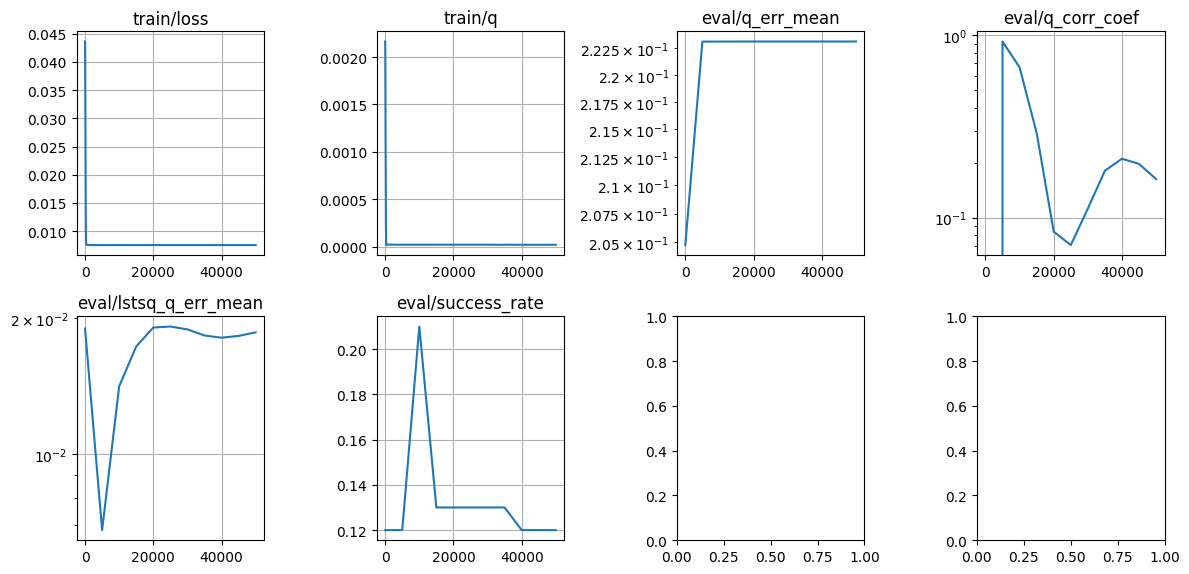

100%|██████████| 50000/50000 [02:44<00:00, 303.87it/s]


In [44]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, p_curgoal=0.0, p_trajgoal=1.0)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['observations'])

def loss_fn(params, batch):
  pos_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'])
  neg_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['observations'])
  
  I = jnp.eye(batch_size)
  logits = I * pos_logits + (1 - I) * neg_logits
  loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=I).mean()
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, opt_state, batch):
  (loss, info), grads = grad_fn(params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  return params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_logits = jnp.diag(plus_logits)
  plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(plus_logits, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  eval_dataset = defaultdict(list)
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_eval_env.reset()
    for _ in range(max_episode_steps):
      action = np.random.choice(np.arange(augmented_env.num_actions), p=pi[obs])
      reward, next_obs = augmented_eval_env.step(action)
      
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs

    for k, v in traj_dataset.items():
      eval_dataset[k].append(v)

  for k, v in eval_dataset.items():
    eval_dataset[k] = np.asarray(v)

  sr = np.mean(np.any(eval_dataset['rewards'] == 1.0, axis=-1))

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  # scaled_q = q * (opt_q_square_discount / q).mean()
  # q_err_mean = jnp.mean(jnp.abs(q - opt_q_square_discount))
  # scaled_q_err_mean = jnp.mean(jnp.abs(scaled_q - opt_q_square_discount))
  # q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, p_curgoal=0.0, p_trajgoal=1.0)
  critic_params, opt_state, loss, info = update_fn(
    critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
crl_metrics = metrics
print(crl_metrics['eval/q_err_mean'][-1])
print(crl_metrics['eval/q_corr_coef'][-1])
print(crl_metrics['eval/lstsq_q_err_mean'][-1])
print(crl_metrics['eval/success_rate'][-1])

[5.00000000e+04 2.23123401e-01]
[5.00000000e+04 3.08380015e-02]
[5.0000000e+04 1.9431008e-02]
[5.0e+04 1.3e-01]


In [ ]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
plus_logits = critic.apply(critic_params, obs, actions, 
                           (augmented_env.num_states - 2) * jnp.ones_like(obs))
plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
q = (1 + discount) / discount * plus_probs
q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
q = q[:env.num_states]

print("pi: ")
print(pi)

pi: 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### TD InfoNCE

In [60]:
s_marg = np.zeros(augmented_env.num_states)
for state in range(augmented_env.num_states):
    s_marg[state] = np.sum(augmented_train_dataset['observations'] == state) / len(augmented_train_dataset['observations'])
s_marg = jnp.asarray(s_marg)
print(s_marg)

[6.0900e-02 3.4880e-02 1.2020e-02 5.2300e-03 2.3200e-03 6.8000e-04
 9.0600e-03 8.7491e-01]


In [61]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

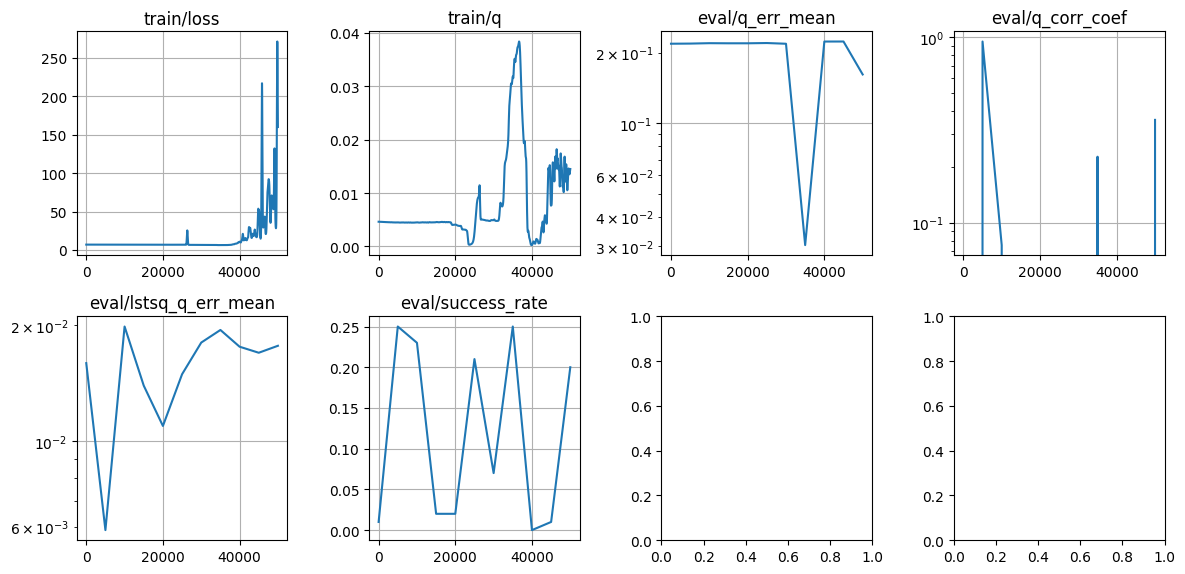

100%|██████████| 50000/50000 [03:00<00:00, 277.49it/s]


In [62]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

s_plus_marg = jnp.sum(augmented_train_dataset['observations'] == env.num_states - 2) / len(augmented_train_dataset['observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['observations'])
  
  random_states = jnp.roll(batch['observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  future_logit1 = critic.apply(
    params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), random_states)
  future_logit2 = critic.apply(
    params, batch['next_observations'], jnp.ones_like(batch['next_observations']), random_states)
  plus_logits1 = critic.apply(params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_logits2 = critic.apply(params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  w = jax.lax.stop_gradient(w)
  w = jnp.clip(w, 0.0, 100.0 / batch_size)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  q = (1 + discount) / discount * jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=3e-4 * 512 * 2)
optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, batch, num_eval_episodes=100, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  # plus_logits = critic.apply(params, obs, actions, 
  #                            (augmented_env.num_states - 2) * jnp.ones_like(obs))
  # plus_logits = jnp.diag(plus_logits)
  # plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  random_states = jnp.roll(batch['observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  
  a = jnp.argmax(plus_log_probs, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)
  
  # evaluation
  eval_dataset = defaultdict(list)
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_eval_env.reset()
    for _ in range(max_episode_steps):
      action = np.random.choice(np.arange(augmented_env.num_actions), p=pi[obs])
      reward, next_obs = augmented_eval_env.step(action)
      
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs

    for k, v in traj_dataset.items():
      eval_dataset[k].append(v)

  for k, v in eval_dataset.items():
    eval_dataset[k] = np.asarray(v)

  sr = np.mean(np.any(eval_dataset['rewards'] == 1.0, axis=-1))

  return sr

def evaluate_fn(params, batch):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  q = (1 + discount) / discount * jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params, batch)
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
    # 'prob_err_mean': prob_err_mean,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [63]:
td_infonce_metrics = metrics
print(td_infonce_metrics['eval/q_err_mean'][-1])
print(td_infonce_metrics['eval/q_corr_coef'][-1])
print(td_infonce_metrics['eval/lstsq_q_err_mean'][-1])
print(td_infonce_metrics['eval/success_rate'][-1])

[5.00000000e+04 1.61446303e-01]
[5.0000000e+04 3.5847798e-01]
[5.00000000e+04 1.76670328e-02]
[5.e+04 2.e-01]


In [64]:
# evaluation the pi
batch = sample_augmented_batch(batch_size)

obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
random_states = jnp.roll(batch['observations'], -1, axis=0)
plus_logits = critic.apply(critic_params, obs, actions, 
                            (augmented_env.num_states - 2) * jnp.ones_like(random_states))
random_logits = critic.apply(critic_params, obs, actions, random_states)
plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])

a = jnp.argmax(plus_log_probs, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

pi: 
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### SGCQL + data augmentation

In [67]:
sample_batch(2)

{'actions': array([0, 1], dtype=int32),
 'next_actions': array([1, 1], dtype=int32),
 'next_observations': array([0, 2], dtype=int32),
 'observations': array([0, 1], dtype=int32),
 'rewards': array([0.005, 0.   ], dtype=float32)}

In [ ]:
def augment_batch(batch):
    aug_batch = batch['observations']
    batch['actions']
    
    return aug_batch

In [66]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)
    
    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'gc_q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=1001):
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  eval_dataset = defaultdict(list)
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    obs = augmented_env.reset()
    for _ in range(max_episode_steps):
      action = np.random.choice(np.arange(augmented_env.num_actions), p=pi[obs])
      reward, next_obs = augmented_env.step(action)
      
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs

    for k, v in traj_dataset.items():
      eval_dataset[k].append(v)

  for k, v in eval_dataset.items():
    eval_dataset[k] = np.asarray(v)

  sr = np.mean(np.any(eval_dataset['rewards'] == 1.0, axis=-1))

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions)
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = gc_q[:env.num_states]
  q = q * (1 + discount) / discount
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  aug_batch = augment_batch(batch)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, aug_batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


### TD InfoNCE

In [ ]:
s_marg = np.zeros(augmented_env.num_states)
for state in range(augmented_env.num_states):
    s_marg[state] = np.sum(augmented_train_dataset['observations'] == state) / len(augmented_train_dataset['observations'])
s_marg = jnp.asarray(s_marg)
print(s_marg)

[0.23331 0.13439 0.05173 0.02329 0.01114 0.00359 0.15526 0.38729]


In [141]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

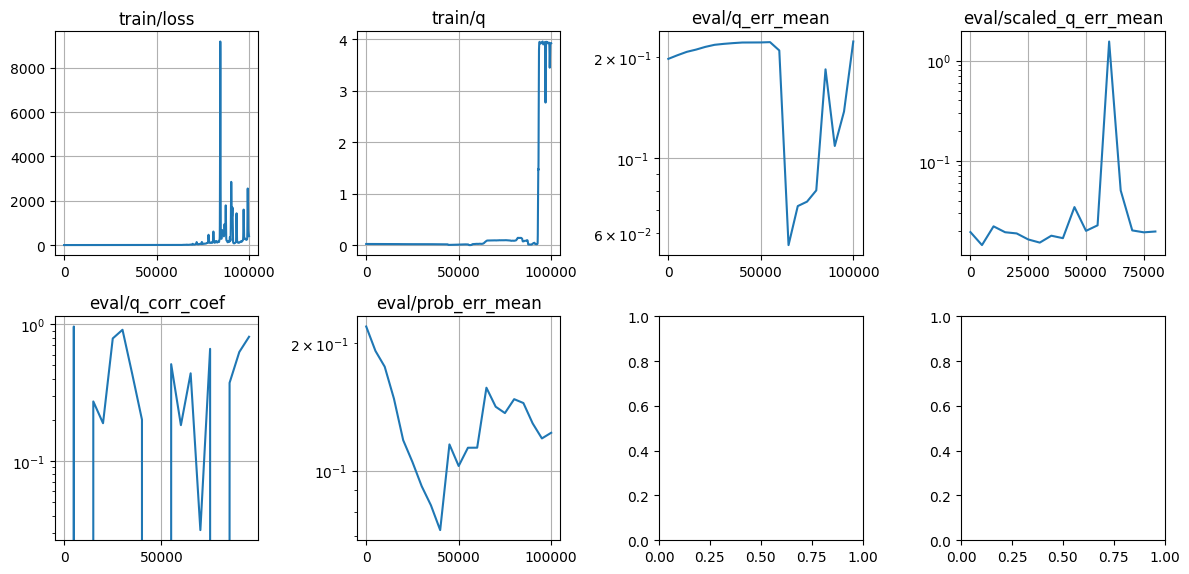

100%|██████████| 100000/100000 [04:08<00:00, 402.42it/s]


In [142]:
batch_size = 1024
tau = 0.005
num_iterations = 100_000
eval_interval = 5_000
log_interval = 5_000

s_plus_marg = jnp.sum(augmented_train_dataset['observations'] == env.num_states - 2) / len(augmented_train_dataset['observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['observations'])
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  future_logit1 = critic.apply(
    params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), random_states)
  future_logit2 = critic.apply(
    params, batch['next_observations'], jnp.ones_like(batch['next_observations']), random_states)
  plus_logits1 = critic.apply(params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_logits2 = critic.apply(params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  w = jax.lax.stop_gradient(w)
  w = jnp.clip(w, 0.0, 100.0 / batch_size)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  q = (1 + discount) / discount * jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=3e-4 * 512 * 2)
optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params, batch):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  q = (1 + discount) / discount * jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = q[:env.num_states]
  scaled_q = q * (opt_q_square_discount / q).mean()
  q_err_mean = jnp.mean(jnp.abs(q - opt_q_square_discount))
  scaled_q_err_mean = jnp.mean(jnp.abs(scaled_q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  probs = jnp.diag(ratios) * s_marg[random_states]
  prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'scaled_q_err_mean': scaled_q_err_mean,
    'q_corr_coef': q_corr_coef,
    'prob_err_mean': prob_err_mean,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/scaled_q_err_mean', 'eval/q_corr_coef', 'eval/prob_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [131]:
td_infonce_metrics = metrics
print(td_infonce_metrics['eval/q_err_mean'][-1])
print(td_infonce_metrics['eval/scaled_q_err_mean'][-1])
print(td_infonce_metrics['eval/q_corr_coef'][-1])

[1.00000000e+05 2.22590744e-01]
[1.00000000e+05 1.30343419e-02]
[1.00000000e+05 9.05344129e-01]


In [132]:
print(s_marg)

[0.23331 0.13439 0.05173 0.02329 0.01114 0.00359 0.15526 0.38729]


In [133]:
print((opt_d_sa / s_marg[None, None]).max())

62.58559


In [140]:

batch = sample_augmented_batch(batch_size)
random_states = jnp.roll(batch['observations'], -1, axis=0)
logits = critic.apply(critic_params, batch['observations'], batch['actions'], random_states)
ratios = jax.nn.softmax(logits, axis=-1) * batch_size

print(jnp.diag(ratios))

probs = jnp.diag(ratios) * s_marg[random_states]

err = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
print(err)

print(batch['observations'][0])
print(batch['actions'][0])
print(random_states[0])
print(probs[0])

print(opt_d_sa[batch['observations'][0], batch['actions'][0], random_states[0]])

[1.8255363  0.         2.5345917  ... 0.         0.40706736 0.6441832 ]
0.16601752
1
0
7
0.70701194
0.3994143563665381


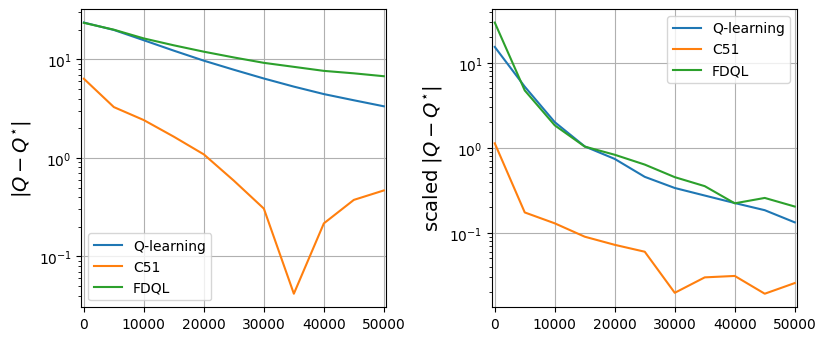

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.2))

metric_name = 'eval/q_err_mean'
ax = axes[0]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'$| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()
ax.grid(zorder=3)

metric_name = 'eval/scaled_q_err_mean'
ax = axes[1]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'scaled $| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()

# ax.set_ylim([-5, 120 + 5])
# ax.set_yticks([0, 120])
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.grid(zorder=3)     

fig.tight_layout(rect=(-0.026, -0.06, 1.02, 1.04))  # rect = (left, bottom, right, top), default: (0, 0, 1, 1)
# filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/convergence_speed_ablation_lc.pdf"
# fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
